# Import

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import pandas as pd
import pyplot_themes as themes
import sys 

# Turn off value-on-slice warning
pd.options.mode.chained_assignment = None  # default='warn'

def make_aesthetic():
    sns.set(style='white', context='poster')
    themes.theme_few(scheme='light')
    plt.rcParams.update({'font.family':'Arial'})

# Make dfs

In [99]:
N = 0 # Window around rumor/announcement to determine rumor_period/announcement_period 
DATE_FINDER = 3 # Window around rumor day to find 'actual' rumor day
OUTPUT_PATH = "../results/graphs/" # Where to save folders 

def make_max_value_dates(df, N):
    """
    Since it's not clear what the exact rumor day is, look at rumor days around GPT-generated rumor day and get 
    the one with max value
    """
    max_rumor_date = {}
    for uid in set(df['kwe'].tolist()):
        max_rumor_date[uid] = max_value_date_helper(df, uid, DATE_FINDER)
    return max_rumor_date

def max_value_date_helper(df, uid, N):
    df2 = df[df['kwe'] == uid]
    df2['abs_rumor_delta'] = np.abs(df2['rumor_delta'])
    filter_df = df2[df2['abs_rumor_delta'] <= N]
    max_date = filter_df.sort_values(['value', 'abs_rumor_delta'], ascending=False).head(1)['date'].tolist()[0]
    return max_date

def truncate_time(x, n):
    if abs(x) <= n:
        return 1 
    else:
        return 0


# Read in data
rumor_data = pd.read_json("../data/rum_data.json").T.reset_index()[['index', 'rumor_day', 'announce_day']]
df = pd.merge(left=pd.read_csv("../data/trend_data_news.csv"), right=rumor_data, left_on='event', right_on='index')
df['search_type'] = df['search_type'].apply(lambda x: x if x!= 'news' else 'google_news')


# Make UID
df['kwe'] = df['kw'] + "_" + df['event']

# Get date difference between date and rumor, announcement day
df['rumor_delta'] = (pd.to_datetime(df['rumor_day']) - pd.to_datetime(df['date'])).dt.days.astype(int)
df['announce_delta'] = (pd.to_datetime(df['announce_day']) - pd.to_datetime(df['date'])).dt.days.astype(int)
max_value_rumor_dict = make_max_value_dates(df, 10)

# Also define a second rumor date 
df['rumor_day2'] = [max_value_rumor_dict[x] for x in df['kwe'].tolist()]
df['rumor2_delta'] = (pd.to_datetime(df['rumor_day2']) - pd.to_datetime(df['date'])).dt.days.astype(int)

# Various pivot tables
searchd = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2', 'announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
kwd = df.groupby(by=['event', 'date', 'kw', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
eventd = df.groupby(by=['event', 'date', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
event_search = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()

# Add features to DFs
for d in [df, kwd, eventd, searchd, event_search]:
    d['rumor_period'] = d['rumor_delta'].apply(lambda x: truncate_time(x, N))
    d['announce_period'] = d['announce_delta'].apply(lambda x: truncate_time(x, N))
    d['rumor2_period'] = d['rumor2_delta'].apply(lambda x: truncate_time(x, N))
    d['control_period'] = (d['rumor_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)
    d['control_period2'] = (d['rumor2_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)

    d['period'] = d.apply(lambda row: 'rumor_period' if row['rumor_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)
    d['period2'] = d.apply(lambda row: 'rumor2_period' if row['rumor2_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)

    d['year'] = pd.to_datetime(d['rumor_day']).dt.year
    if 'kw' in d.columns:
        d['val_prop'] = d['value']/d.groupby(['kw', 'event'])['value'].transform('sum')
    if "search_type" in d.columns:
        d['search_type'] = pd.Categorical(d['search_type'],
                                   categories=["web", "google_news", "youtube"],
                                   ordered=True)
        

# Let's just make sure we got values for every kw/search combo    
grouped = df.groupby(['kwe'])['value'].max().reset_index()
no_nan_val = sum(grouped['value'].isna()) == 0 # No KWxSearchType is nan
every_kw_has_100 = np.min(grouped['value'])==100 # For every KW x SearchType there's a peak 
print("No Nans:", no_nan_val)
print("Every kw/search type has one pt which hits 100:", every_kw_has_100)
if (no_nan_val and every_kw_has_100):
    print("Proceed...data is valid")

No Nans: True
Every kw/search type has one pt which hits 100: True
Proceed...data is valid


# Descriptive Plots

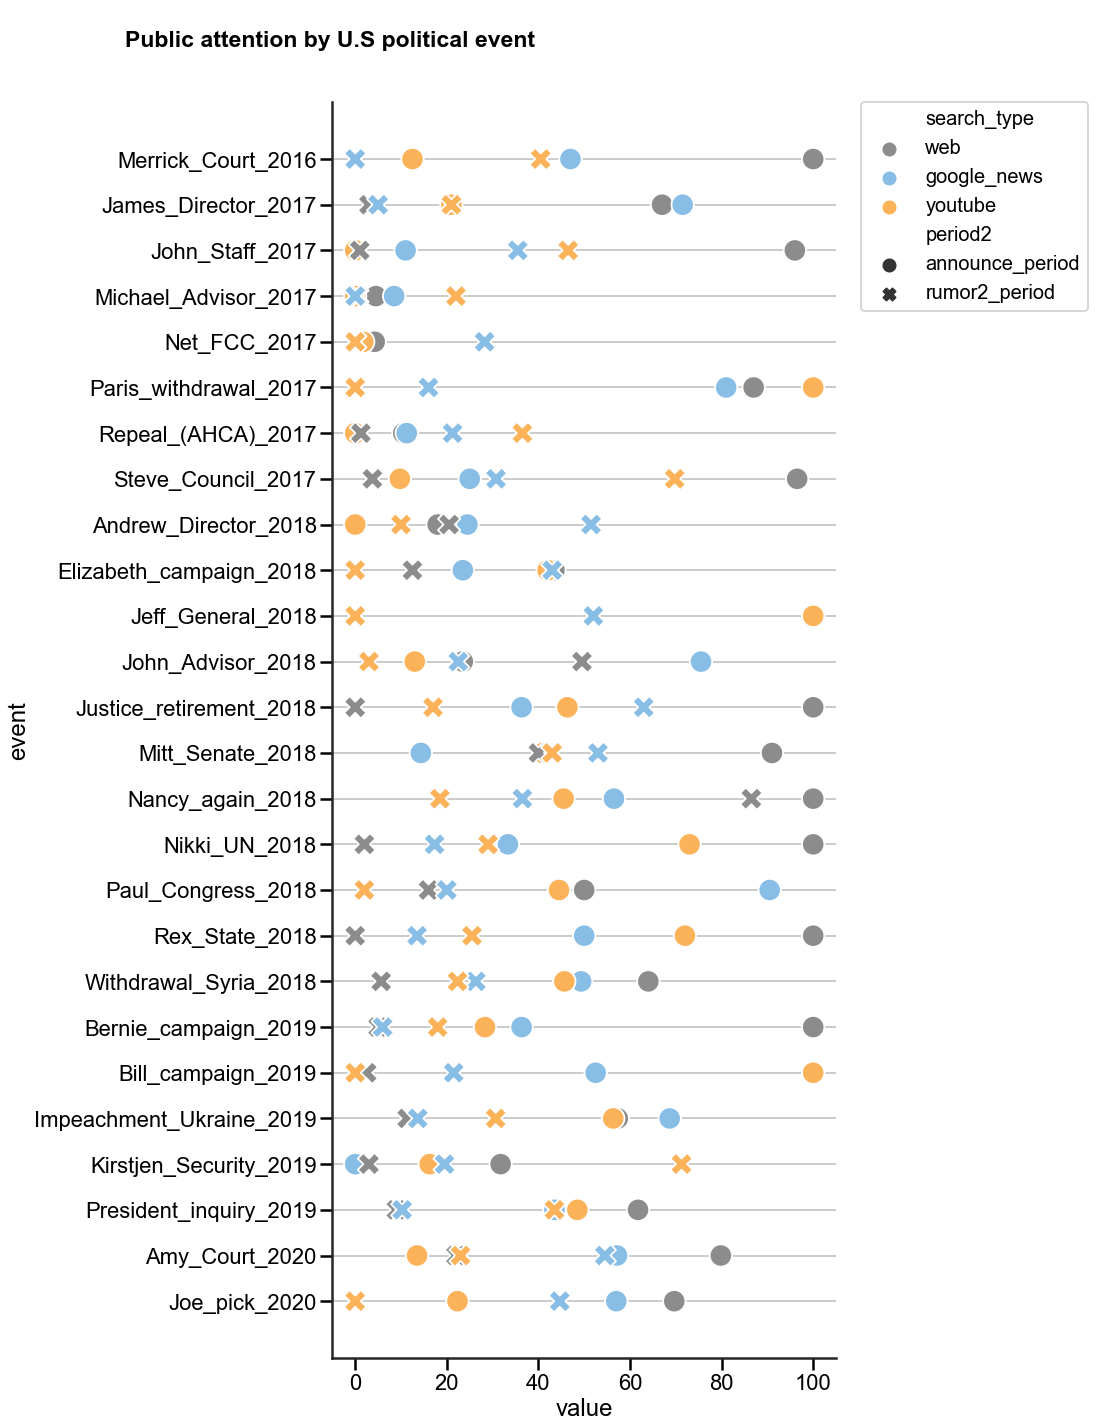

In [206]:
plt.figure(figsize=(16,20))
make_aesthetic()
edf = event_search.groupby(by=['period2', 'event', 'search_type']).mean().reset_index()
sns.scatterplot(data=edf.query("control_period2==0").sort_values(by=['year', 'event']), y='event', s=500, x='value', style='period2', hue='search_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20, markerscale=1)

plt.suptitle(
    "\nPublic attention by U.S political event",
    fontsize=23,
    fontweight="bold",
    x=0.125,
    y=1,
    ha="left",
)
plt.tight_layout()
plt.grid(linewidth=2, axis='y')  #just add this
sns.despine()
plt.savefig(f"{OUTPUT_PATH}all_events.png", dpi=300, bbox_inches='tight')

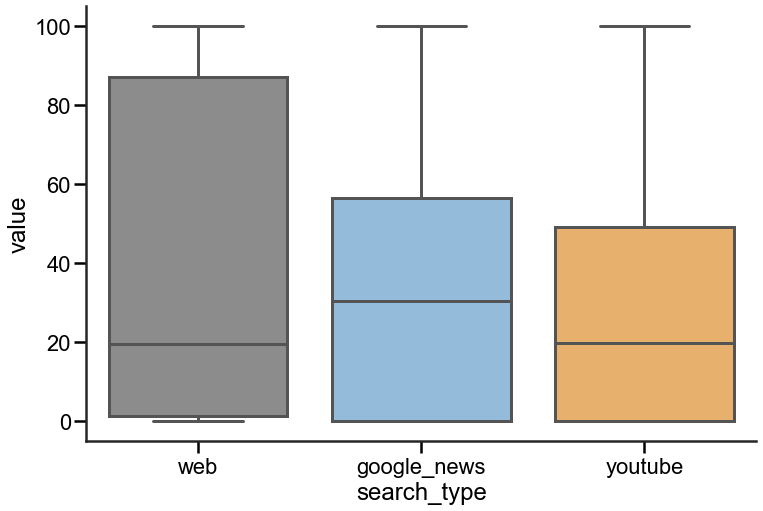

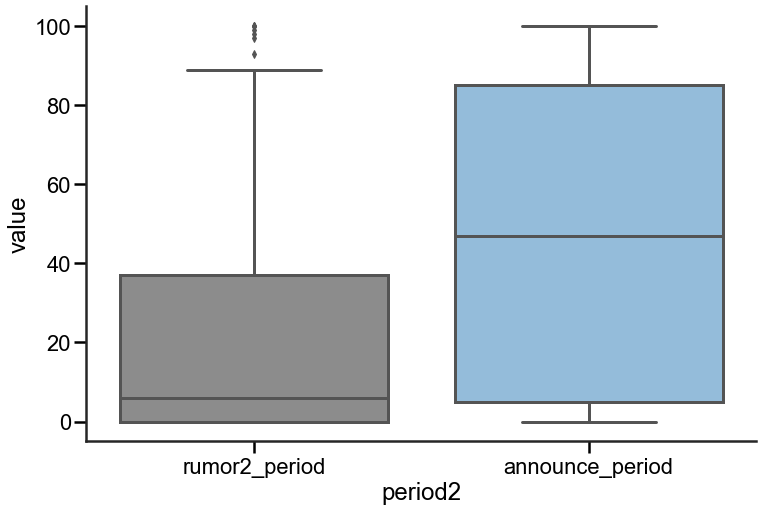

In [212]:
for break_out in ['search_type', 'period2']:
    make_aesthetic()
    sns.boxplot(data=event_search.query("control_period2==0"), x=break_out, y='value')
    sns.despine()
    plt.show()

# Announcement Period X Search Type

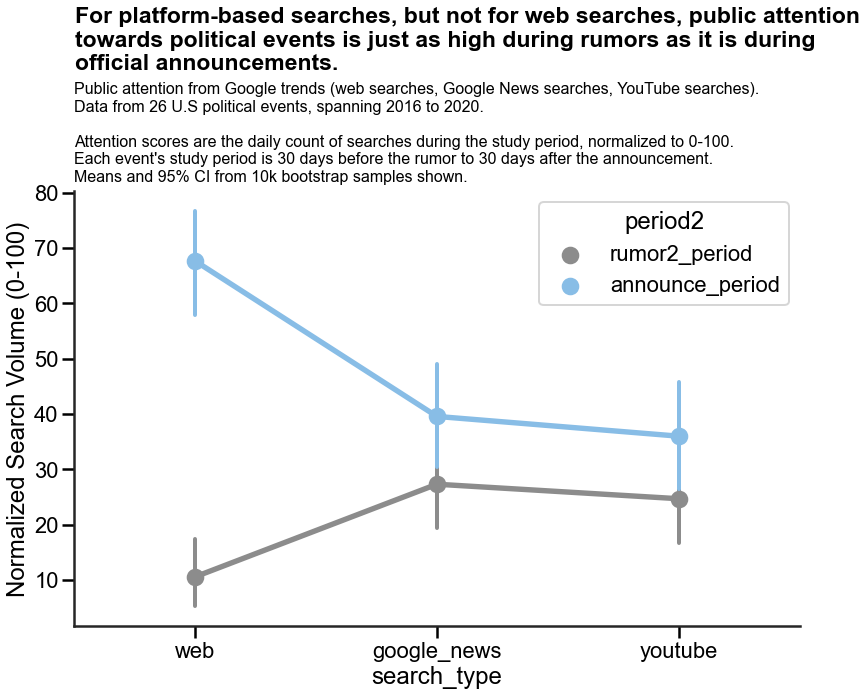

In [213]:
import matplotlib
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager

make_aesthetic()
plt.rcParams.update({'font.family':'Arial'})

plt.figure(figsize=(13,8))

sns.pointplot(data=event_search.query("control_period2==0"), 
              errwidth=4, 
              errorbar='ci', 
              scale=1, 
              seed=416,
              n_boot=10000,
              hue='period2', 
              x='search_type', 
              y='value')


plt.ylabel("Normalized Search Volume (0-100)")

plt.title(
    (f"""\nPublic attention from Google trends (web searches, Google News searches, YouTube searches).\nData from {event_search['event'].nunique()} U.S political events, spanning {np.min(event_search['year'])} to {np.max(event_search['year'])}.\n\nAttention scores are the daily count of searches during the study period, normalized to 0-100.\nEach event's study period is 30 days before the rumor to 30 days after the announcement.\nMeans and 95% CI from 10k bootstrap samples shown."""),
    fontsize=16,
    pad=10,
    loc="left",
)

plt.suptitle(
    "For platform-based searches, but not for web searches, public attention\ntowards political events is just as high during rumors as it is during\nofficial announcements.",
    fontsize=23,
    fontweight="bold",
    x=0.126,
    y=1.2,
    ha="left",
)

sns.despine()
plt.savefig(f"{OUTPUT_PATH}attn_interaction.png", dpi=300, bbox_inches='tight')


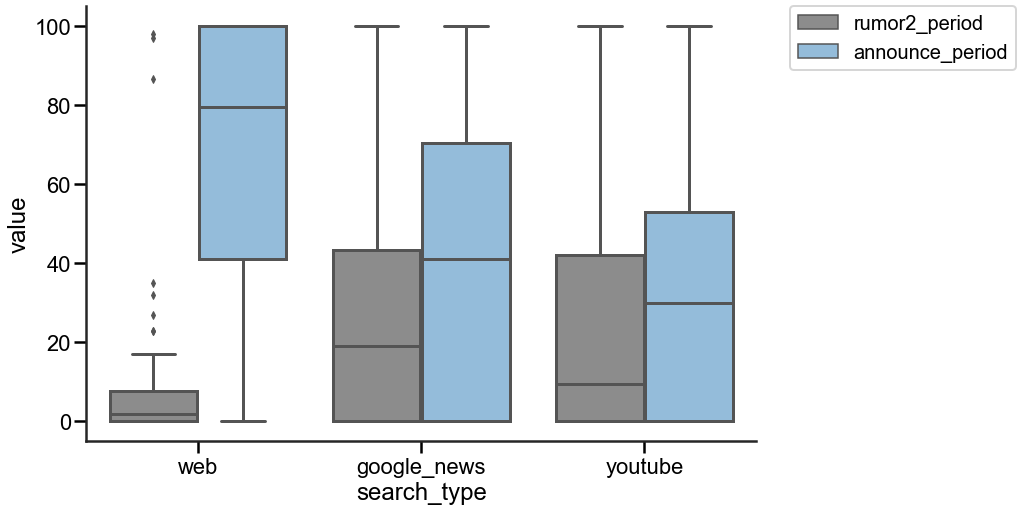

In [209]:
make_aesthetic()

sns.boxplot(data=event_search.query("control_period2==0"), 
              hue='period2', 
              x='search_type', 
              y='value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20, markerscale=1)
sns.despine()

# Get beta coefficients (but mixed fx didn't converge, and use EMM in R for real)

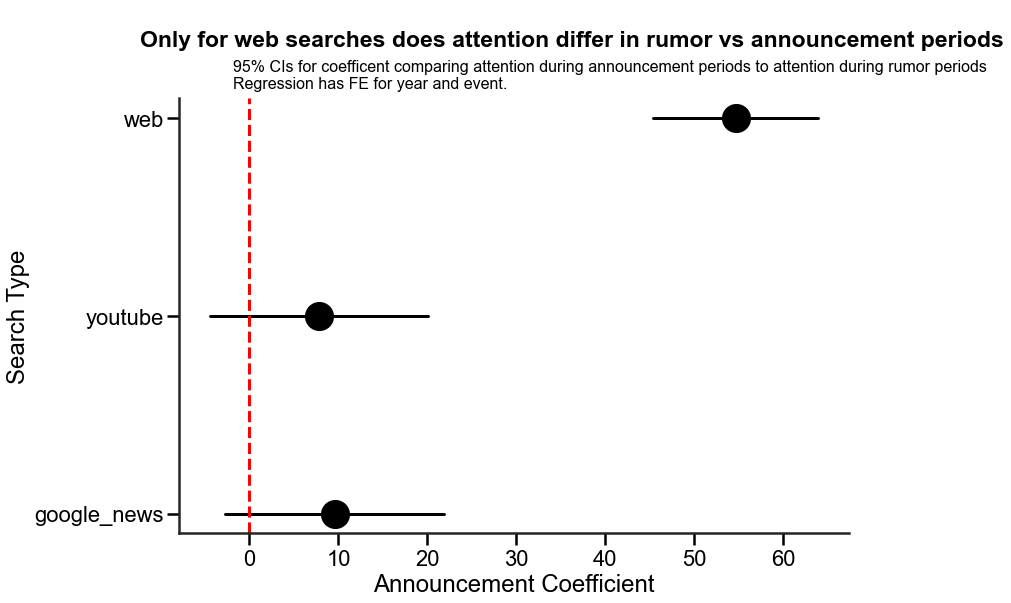

In [321]:

beta_dfs = []
for search_type in set(df['search_type'].tolist()):
    tdf = df.query("search_type=='{}'&period2!='control'".format(search_type))
    md = smf.ols("value ~ C(year) + C(period2, Treatment('rumor2_period')) + C(event)", tdf).fit()

    coef_period2 = md.params["C(period2, Treatment('rumor2_period'))[T.announce_period]"]
    conf_int_period2 = md.conf_int().loc["C(period2, Treatment('rumor2_period'))[T.announce_period]"]
    summary_df = pd.DataFrame({"Coefficient": [coef_period2],
                               "95% CI Lower": [conf_int_period2[0]],
                               "95% CI Upper": [conf_int_period2[1]],
                              "search_type":[search_type]},
                              index=["period2"])
    beta_dfs.append(summary_df)

    
sns.set(style="whitegrid")

# Create a scatter plot for coefficients
make_aesthetic()
ax = sns.scatterplot(x="Coefficient", y="search_type", data=beta_df, marker='o', color='black', s=1000)
for index, row in beta_df.iterrows():
    plt.plot((row["95% CI Lower"], row["95% CI Upper"]), (row["search_type"], row["search_type"]), 'black', linewidth=3)
plt.axvline(x=0, color='red', linestyle='--')
sns.despine()
plt.xlabel("Announcement Coefficient")
plt.ylabel("Search Type")
plt.suptitle("\nOnly for web searches does attention differ in rumor vs announcement periods", 
    fontsize=23,
    fontweight="bold",
    x=0.08,
    y=1.04,
    ha="left",)

plt.title("95% CIs for coefficent comparing attention during announcement periods to attention during rumor periods\nRegression has FE for year and event.", 
    fontsize=16,x=0.08, pad=10, ha='left')  
plt.savefig(f"{OUTPUT_PATH}coefficient.png", dpi=300, bbox_inches='tight')


# Correlations

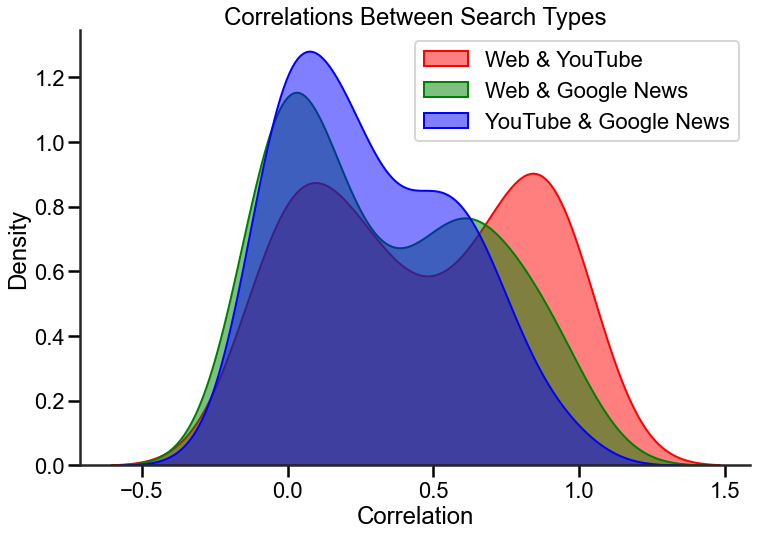

In [323]:
def get_cor_for_uid(df):
    uids = set(df['kwe'].tolist())
    all_cors = []
    for uid in uids:
        all_cors.append(get_cor_for_uid_helper(df, uid))
    df = pd.DataFrame(all_cors)
    df.columns = ['event', 'kw', "web_news", "web_yt", "yt_news"]
    df['kwe'] = df['kw'] + "_" + df['event']
    return df 


def get_cor_for_uid_helper(df, uid):
    cors = []
    kw = uid.split("_")[0]
    event = "_".join(uid.split("_")[1:])
    a = df[df['kwe'] == uid]
    pivot_df = a.pivot_table(index='date', columns='search_type', values='value')
    l = pivot_df.corr().to_dict()
    row = [event, kw, l['web']['google_news'],l['web']['youtube'],l['youtube']['google_news']]
    return row

cor_df = get_cor_for_uid(df)


# PLOT CORRELATIONS
################
make_aesthetic()
# Create a histogram for each correlation using seaborn's 'kdeplot' function
sns.kdeplot(data=cor_df['web_yt'], label='Web & YouTube', shade=True, alpha=0.5, color='red')
sns.kdeplot(data=cor_df['web_news'], label='Web & Google News', shade=True, alpha=0.5, color='green')

sns.kdeplot(data=cor_df['yt_news'], label='YouTube & Google News', shade=True, alpha=0.5, color='blue')
sns.despine()

# Add title and labels to the plot
plt.title('Correlations Between Search Types')
plt.xlabel('Correlation')
plt.ylabel('Density')

# Display the legend
plt.legend(loc='upper right')

# Show the plot
################
plt.savefig(f"{OUTPUT_PATH}cors.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
cor

# Mixed Model (use R for any real analysis)

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df['kwe'] = df['kw'] + df['event']
tdf = df.query("control_period!=999")
md = smf.mixedlm("value ~ C(year) + C(period)*C(search_type, Treatment('web'))", tdf, groups=tdf['kwe']).fit()
ols = smf.ols("value ~ C(year) + C(period)*C(search_type, Treatment('web'))", tdf).fit()

## Mixed model, random intercepts for event#KW

In [30]:
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Mixed Linear Model Regression Results
========================================================================================================================
Model:                                 MixedLM                      Dependent Variable:                      value      
No. Observations:                      16314                        Method:                                  REML       
No. Groups:                            64                           Scale:                                   319.2437   
Min. group size:                       204                          Log-Likelihood:                          -70277.5572
Max. group size:                       351                          Converged:                               Yes        
Mean group size:                       254.9                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  61.716    5.768  10.700 0.000  50.412  73.021
C(year)[T.2017]                                                             2.248    5.642   0.398 0.690  -8.811  13.307
C(year)[T.2018]                                                             3.402    5.528   0.615 0.538  -7.433  14.237
C(year)[T.2019]                                                            10.168    5.687   1.788 0.074  -0.979  21.314
C(year)[T.2020]                                                             3.258    6.033   0.540 0.589  -8.566  15.082
C(period)[T.control]                                                      -58.496    2.247 -26.034 0.000 -62.900 -54.093
C(period)[T.rumor_period]                                                 -58.875    3.159 -18.640 0.000 -65.066 -52.684
C(search_type, Treatment('web'))[T.youtube]                               -32.844    3.159 -10.398 0.000 -39.034 -26.653
C(search_type, Treatment('web'))[T.google_news]                           -27.031    3.159  -8.558 0.000 -33.222 -20.841
C(period)[T.control]:C(search_type, Treatment('web'))[T.youtube]           35.832    3.178  11.277 0.000  29.604  42.060
C(period)[T.rumor_period]:C(search_type, Treatment('web'))[T.youtube]      32.984    4.467   7.384 0.000  24.230  41.739
C(period)[T.control]:C(search_type, Treatment('web'))[T.google_news]       29.735    3.178   9.358 0.000  23.507  35.963
C(period)[T.rumor_period]:C(search_type, Treatment('web'))[T.google_news]  32.937    4.467   7.374 0.000  24.183  41.692
Group Var                                                                  55.300    0.585                              
========================================================================================================================

"""

## OLS, event fe

In [39]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     67.32
Date:                Mon, 20 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:52:28   Log-Likelihood:                -70817.
No. Observations:               16314   AIC:                         1.417e+05
Df Residuals:                   16280   BIC:                         1.420e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                       -1.861e+12    9.3e+12     -0.200      0.841   -2.01e+13    1.64e+13
C(year)[T.2017]                                  2.239e+12   1.12e+13      0.200      0.841   -1.97e+13    2.42e+13
C(year)[T.2018]                                  2.847e+12   1.42e+13      0.200      0.841    -2.5e+13    3.07e+13
C(year)[T.2019]                                  2.462e+12   1.23e+13      0.200      0.841   -2.16e+13    2.66e+13
C(year)[T.2020]                                  1.861e+12    9.3e+12      0.200      0.841   -1.64e+13    2.01e+13
period2[T.control]                                -28.9528      2.339    -12.380      0.000     -33.537     -24.369
period2[T.rumor2_period]                           -9.5616      3.287     -2.909      0.004     -16.005      -3.118
search_type[T.web]                                 27.0265      3.288      8.221      0.000      20.583      33.470
search_type[T.youtube]                             -5.8139      3.287     -1.768      0.077     -12.258       0.630
C(event)[T.Andrew_Director_2018]                -9.854e+11   4.92e+12     -0.200      0.841   -1.06e+13    8.66e+12
C(event)[T.Bernie_campaign_2019]                -6.012e+11      3e+12     -0.200      0.841   -6.49e+12    5.28e+12
C(event)[T.Bill_campaign_2019]                  -6.012e+11      3e+12     -0.200      0.841   -6.49e+12    5.28e+12
C(event)[T.Elizabeth_campaign_2018]             -9.854e+11   4.92e+12     -0.200      0.841   -1.06e+13    8.66e+12
C(event)[T.Impeachment_Ukraine_2019]            -6.012e+11      3e+12     -0.200      0.841   -6.49e+12    5.28e+12
C(event)[T.James_Director_2017]                 -3.781e+11   1.89e+12     -0.200      0.841   -4.08e+12    3.32e+12
C(event)[T.Jeff_General_2018]                   -9.854e+11   4.92e+12     -0.200      0.841   -1.06e+13    8.66e+12
C(event)[T.Joe_pick_2020]                          -2.1473      0.913     -2.353      0.019      -3.936      -0.359
C(event)[T.John_Advisor_2018]                   -9.854e+11   4.92e+12     -0.200      0.841   -1.06e+13    8.66e+12
C(event)[T.John_Staff_2017]                     -3.781e+11   1.89e+12     -0.200      0.841   -4.08e+12    3.32e+12
C(event)[T.Justice_retirement_2018]             -9.854e+11   4.92e+12     -0.200      0.841   -1.06e+13    8.66e+12
C(event)[T.Kirstjen_Security_2019]              -6.012e+11      3e+12     -0.200      0.841   -6.49e+12    5.28e+12
C(event)[T.Merrick_Court_2016]                   1.861e+12    9.3e+12      0.200      0.841   -1.64e+13    2.01e+13
C(event)[T.Michael_Advisor_2017]                -3.781e+11   1.89e+12     -0.200      0.841   -4.08e+12    3.32e+12
C(event)[T.Mitt_Senate_2018]                    -9.854e+11   4.92e+